## 1. Classification Using Hand-Crafted Features
### (a) You must use the VizWiz dataset with its pre-defined train/validation/test split.

In [942]:
import pandas as pd
import numpy as np
import os
import json
from pprint import pprint
import requests
from skimage import io
import cv2  # /usr/local/Cellar/opencv/3.4.3
import matplotlib.pyplot as plt
import json
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

In [628]:
### remove keys before upload ### 
subscription_key_text 
text_analytics_base_url

# extract text features using MS Azure
language_api_url = text_analytics_base_url + 'languages'
sentiment_api_url = text_analytics_base_url + 'sentiment'
key_phrase_api_url = text_analytics_base_url + 'keyPhrases'

In [621]:
base_url = 'https://ivc.ischool.utexas.edu/VizWiz/data'
split = 'train'
annFile = '%s/Annotations/%s.json'%(base_url, split)
imgDir = '%s/Images'%base_url
print(annFile)
print(imgDir)

# Retrieve file from URL and store it locally
annotations = requests.get(annFile, allow_redirects=True)
print(annotations.status_code)

https://ivc.ischool.utexas.edu/VizWiz/data/Annotations/train.json
https://ivc.ischool.utexas.edu/VizWiz/data/Images
200


In [62]:
data = pd.DataFrame(columns=['image','question','answerable'])
labels = annotations.json()

In [64]:
labels[0]

{'answerable': 1,
 'image': 'VizWiz_train_000000000000.jpg',
 'question': "What's the name of this product?",
 'answer_type': 'other',
 'answers': [{'answer_confidence': 'yes', 'answer': 'basil leaves'},
  {'answer_confidence': 'yes', 'answer': 'basil leaves'},
  {'answer_confidence': 'yes', 'answer': 'basil'},
  {'answer_confidence': 'yes', 'answer': 'basil'},
  {'answer_confidence': 'yes', 'answer': 'basil leaves'},
  {'answer_confidence': 'yes', 'answer': 'basil leaves'},
  {'answer_confidence': 'yes', 'answer': 'basil leaves'},
  {'answer_confidence': 'yes', 'answer': 'basil leaves'},
  {'answer_confidence': 'yes', 'answer': 'basil leaves'},
  {'answer_confidence': 'yes', 'answer': 'basil'}]}

In [65]:
labels = annotations.json()

for vq in labels[0:20000]:
    
    image_name = vq['image']
    question = vq['question']
    label = vq['answerable']
    
    sample = pd.DataFrame({'image':[image_name], 'question':[question], 'answerable':[label]})
    data = pd.concat([data,sample], ignore_index=True)

In [66]:
data.shape

(20000, 3)

In [432]:
data.isnull().any()

image         False
question      False
answerable    False
dtype: bool

In [67]:
%store data

Stored 'data' (DataFrame)


In [515]:
# sample 600 images
%store -r data
df = data.sample(600).reset_index()

In [516]:
df.head(5)

,index,image,question,answerable
0,7190,VizWiz_train_000000007190.jpg,What is this?,1
1,6444,VizWiz_train_000000006444.jpg,What is on this page?,1
2,14211,VizWiz_train_000000014211.jpg,What color is this shirt?,0
3,10324,VizWiz_train_000000010324.jpg,What is this?,1
4,5318,VizWiz_train_000000005318.jpg,What is written on the paper?,0


In [519]:
df['answerable'].value_counts()

1    421
0    179
Name: answerable, dtype: int64

In [129]:
data['answerable'].value_counts()

1    14269
0     5731
Name: answerable, dtype: int64

In [980]:
# The distribution of 'answerable' (Y) in all original data. 
# A trivial classifier that classifies all Y as '1' can achieve accuracy of approx. 71%. 
# Any subsequent model should compare to this baseline.

## (b) Define a feature representation for each visual question that uses:
### i. Image-based features

In [635]:
def sift(np_img, plot=False):
    """ https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html """
    grey = cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY)
    sift_obj = cv2.xfeatures2d.SIFT_create()
    kp, dsc = sift_obj.detectAndCompute(grey, None)
    if plot:
        img2 = cv2.drawKeypoints(grey, kp, np_img)
        plt.imshow(img2)
        plt.show()
    return dsc
    
def color_hist(np_img, plot=False):
    """ https://docs.opencv.org/3.1.0/d1/db7/tutorial_py_histogram_begins.html """
    grey = cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY) # using channel 0 for convenience; should be 3D for RGB
    hist = cv2.calcHist([grey], [0], None, [256], [0,256])
    if plot: 
        plot.hist(np_img.ravel(), 256, [0,256])
        plt.show()
    return hist

def orb(np_img, plot=False):
    """ https://docs.opencv.org/3.3.0/d1/d89/tutorial_py_orb.html """
    orb_obj = cv2.ORB_create()
    kp = orb_obj.detect(np_img, None)
    kp, dsc = orb_obj.compute(np_img, kp)
    if plot:
        img2 = cv2.drawKeypoints(np_img, kp, None, color=(0,255,0), flags=0)
        plt.imshow(img2)
        plt.show()
    return dsc

def kaze(np_img, vector_size=32):
    """ corners """
    alg = cv2.KAZE_create()
    kps = alg.detect(np_img)
    kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
    kps, dsc = alg.compute(np_img, kps)

    dsc = dsc.flatten()
    needed_size = (vector_size * 64)
    if dsc.size < needed_size:
        dsc = np.concatenate([dsc, np.zeros(needed_size-dsc.size)])
    return dsc



def extract_feature(np_img, vector_size=32):
    res = {}
    try:
        res['color_histogram'] = color_hist(np_img)
        # res['kaze'] = kaze(np_img)
        res['sift'] = sift(np_img)
        res['orb'] = orb(np_img)
    except cv2.error as e:
        return e
    return res


def process_images(input_df):
    
    output_df = pd.DataFrame()
    
    for row_index, row in input_df.iterrows():
        
        index, img_name = row[0], row[1]
        image_dir = 'https://ivc.ischool.utexas.edu/VizWiz/data/Images/%s'%img_name
        np_img = io.imread(image_dir, mode='RGB')
        
        features = extract_feature(np_img)
        
        temp = pd.concat([pd.DataFrame({'index':[index],'img_name':[img_name]}),
                          pd.DataFrame().append(features, ignore_index=True)], 
                         axis=1)
        output_df = pd.concat([output_df, temp], axis=0, ignore_index=True)
        
    return output_df

In [ ]:
image_features = process_images(df)

In [ ]:
image_features.shape

In [ ]:
image_features.head(1)

In [ ]:
image_features.to_csv('image_features.csv', sep=',')

### ii. Question-based features

In [526]:
def extract_keywords(documents):
    headers = {"Ocp-Apim-Subscription-Key": subscription_key_text}
    response = requests.post(key_phrase_api_url, headers=headers, json=documents)
    languages = response.json()
    try:
        return languages
    except KeyError:
        print("error index:", index, "error question:", question)
        print(languages)
        return 
    

def process_questions(input_df):
    """ get keywords from Azure API """
    arr = []
    
    for row_index, row in df.iterrows():
        
        curr = {}
        
        index, question = row['index'], row['question']
        label = row['answerable']
        
        curr["language"] = "en"
        curr["id"] = index
        curr["text"] = question
        
        arr.append(curr)
    
    documents = {'documents': arr}
    keywords = extract_keywords(documents)
    return keywords

In [527]:
keywords_dict = process_questions(df)

In [528]:
# examples of failed keyword extractions (recognized as stop words)
df.loc[df['index']==9551]

,index,image,question,answerable


In [529]:
extract_keywords({'documents':[{'language':'en', 'id':'11155', 'text': 'What does this can say?'}]})

{'documents': [{'id': '11155', 'keyPhrases': []}], 'errors': []}

In [530]:
extract_keywords({'documents':[{'language':'en', 'id':'9551', 'text': 'What is this?'}]})

{'documents': [{'id': '9551', 'keyPhrases': []}], 'errors': []}

In [531]:
text_features = pd.DataFrame(keywords_dict['documents'])

In [933]:
def clean_text_features(input_df_):
    output_df = input_df_.copy()
    for i in range(len(output_df)):
        kw = output_df.iloc[i,1]
        output_df.iloc[i,1] = " ".join(str(w) for w in kw)
    return output_df

In [580]:
cleaned_text_features = clean_text_features(text_features)
cleaned_text_features.shape

(600, 2)

In [583]:
cleaned_text_features.rename(index=str, columns={"id":"index", "keyPhrases":"keywords"}, inplace=True)

In [584]:
cleaned_text_features.to_csv('text_features.csv', sep=',')

In [585]:
image = image_features.copy()
text = cleaned_text_features.copy()
orig = df.copy()[['index','answerable']]

In [586]:
text['index'] = text['index'].astype('int64')

In [587]:
features = text.merge(image, on='index', left_index=True, validate='one_to_one').merge(orig, on='index', left_index=True, validate='one_to_one').set_index('index')
features.shape

(600, 6)

In [784]:
features.reset_index(inplace=True)

# For records that Azure fail to extract any keyword, change empty string to null
features['keywords'].replace(r'^\s*$', np.nan, regex=True, inplace=True)

features['keywords'] = features['keywords'].str.lower()

In [787]:
features.isnull().any()

index               False
keywords             True
img_name            False
color_histogram     False
orb                  True
sift                 True
answerable          False
num_of_keypoints    False
dtype: bool

In [721]:
# since each image has different number of SIFT keypoints, count the number of keypoints and use as predictor
# orb and color histogram all have the same length
# for images that don't have SIFT or ORB keypoints, SIFT count is 0

def count_keypoints(input_df):
    
    output_df = input_df.copy()
    output_df['num_of_keypoints'] = ""
    
    for row_index, row in input_df.iterrows():
        input_df.iloc[row_index,5]
        try:
            kp_ct = len(input_df.iloc[row_index,5])
        except TypeError:     # no keypoints
            kp_ct = 0
        output_df.iloc[row_index,7] = kp_ct
    
    return output_df

In [788]:
features = count_keypoints(features)
features.head(2)

,index,keywords,img_name,color_histogram,orb,sift,answerable,num_of_keypoints
0,7190,NaN,VizWiz_train_000000007190.jpg,"[[17.0], [59.0], [232.0], [570.0], [1561.0], [...","[[248, 122, 62, 50, 124, 205, 83, 80, 187, 252...","[[3.0, 1.0, 0.0, 2.0, 126.0, 19.0, 0.0, 0.0, 1...",1,790
1,6444,page,VizWiz_train_000000006444.jpg,"[[80.0], [5472.0], [31235.0], [41287.0], [4397...","[[42, 191, 114, 227, 119, 255, 186, 83, 27, 23...","[[0.0, 0.0, 27.0, 133.0, 6.0, 0.0, 0.0, 0.0, 2...",1,4708


### (c) You can use any transformations (e.g., feature dimension reduction techniques) and classiffication models (e.g., SVM, ensemble) of your choice to train your system to predict whether a visual question is answerable using the input features. For full credit, you need to train using at least 500 training visual questions. (Code)

#### due to time limit, use keywords and number of keypoints from SIFT as two predictors
#### split 600 samples into training and validation sets

In [808]:
features['keywords'].fillna(value='0', inplace=True)

In [822]:
X = features[['keywords', 'num_of_keypoints']].values
Y = features['answerable'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.15, shuffle=True)

In [850]:
# convert keywrods to vectors
train_corpus = X_train[:,0]
test_corpus = X_test[:,0]

vec = CountVectorizer()
train_corpus_vec = vec.fit_transform(train_corpus)
test_corpus_vec = vec.transform(test_corpus)

train_text = train_corpus_vec.toarray()
test_text = test_corpus_vec.toarray()

In [867]:
# join with visual feature (num of keypoints)
X_train = np.c_[train_text, X_train[:,1]]
X_test = np.c_[test_text, X_test[:,1]]
print(X_train.shape, X_test.shape)

(510, 349) (90, 349)


#### preprocessing 

In [868]:
# standardize
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

/Users/edithzeng/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [928]:
# helper functions for PCA: find optimal number of PC and reduce dimensionality
def plot_explained_variance(n_feature, X_train):
    pca = PCA(n_feature)
    pca_full = pca.fit(X_train)
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
    plt.xlabel("number of principal components")
    plt.ylabel("cumulative explained variance")
    plt.grid(color='grey',linestyle='-',alpha=0.2)
    plt.show()
    
def preprocess_pca(X_train, X_test, dim, r=None):
    pca = PCA(n_components=dim, random_state=r)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

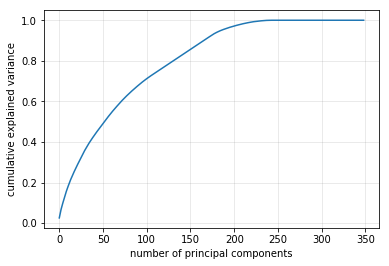

In [929]:
plot_explained_variance(349, X_train_scaled)

In [874]:
X_train_pca, X_test_pca = preprocess_pca(X_train_scaled, X_test_scaled, 200)

In [882]:
Y_test.dtype

dtype('O')

In [893]:
Y_train = Y_train.astype(float)
Y_test = Y_test.astype(float)

#### modeling

In [948]:
kf = KFold(n_splits=5, shuffle=False, random_state=1)

def logit(X_train, X_test, Y_train, Y_test):
    
    cv_scores = []
    C_list = [0.5, 1.0, 2.5, 5.0]
    
    for c in C_list:
        cv_model = LogisticRegression(penalty='l2', C=c, 
                                      class_weight={0.:0.29, 1.:0.71}, 
                                      random_state=2, 
                                      warm_start=True)
        score = np.mean(cross_val_score(cv_model, X_train, Y_train, cv=kf))
        cv_scores.append(score)
        
    cv_scores = np.asarray(cv_scores)
    
    print("10-fold cross-validated score on training set:", np.mean(cv_scores))
    
    best_C = C_list[cv_scores.argmax()]
    print("Best C =", best_C)
    model = LogisticRegression(C=best_C, random_state=2, warm_start=True)
    model.fit(X_train, Y_train)
    
    print("Best score on test set:", model.score(X_test, Y_test))
    

def knn(X_train, X_test, Y_train, Y_test):
    
    cv_scores = []
    k_list = [5, 10, 20, 30, 50, 80, 120]

    for k in k_list:
        cv_model = KNeighborsClassifier(n_neighbors=k)
        score = np.mean(cross_val_score(cv_model, X_train, Y_train, cv=kf))
        cv_scores.append(score)
    cv_scores = np.asarray(cv_scores)
    print("10-fold cross-validated score on training set:", np.mean(cv_scores))
    
    best_k = k_list[cv_scores.argmax()]
    print("Best K =", best_k)
    model = KNeighborsClassifier(n_neighbors=best_k)
    model.fit(X_train, Y_train)

    print("Best score on test set:", model.score(X_test, Y_test))
    
    
def lda(X_train, X_test, Y_train, Y_test):
    
    cv_scores = np.mean(cross_val_score(LinearDiscriminantAnalysis(), X_train, Y_train, cv=kf))
    print("10-fold cross validation score on training set:", np.mean(cv_scores))
    
    model = LinearDiscriminantAnalysis()
    model.fit(X_train, Y_train)
    
    print("Best score on test set:", model.score(X_test, Y_test))
    
def rf(X_train, X_test, Y_train, Y_test, fold=10):
    scores = []
    n_list = [150, 200, 300, 400]
    for n in n_list:
        model = RandomForestClassifier(n_estimators=n, max_features='sqrt', oob_score=True, warm_start=True)
        model.fit(X_train, Y_train)
        scores.append(model.oob_score_)
    scores = np.asarray(scores)
    best_n = n_list[scores.argmax()]
    print("best num of trees:", best_n)
    model = RandomForestClassifier(n_estimators=best_n, max_features='sqrt', oob_score=True, warm_start=True)
    model.fit(X_train, Y_train)
    return model.score(X_test, Y_test)
    

def svm(X_train, X_test, Y_train, Y_test):
    
    cv_scores = []
    C_list = [.0001, .001, .01, .1, .5, 1, 2, 5, 10]
    for n in C_list:
        cv_model = LinearSVC(loss='hinge', C=n, random_state=7)
        score = np.mean(cross_val_score(cv_model, X_train, Y_train, cv=kf))
        cv_scores.append(score)
    cv_scores = np.asarray(cv_scores)
    
    best_c = C_list[cv_scores.argmax()]
    model = LinearSVC(loss='hinge', C=best_c, random_state=7)
    model.fit(X_train, Y_train)
    print('best C:', best_c)

    return model.score(X_test, Y_test)

In [901]:
logit(X_train_pca, X_test_pca, Y_train, Y_test)

10-fold cross-validated score on training set: 0.6799019607843138
Best C = 1.0
Best score on test set: 0.7222222222222222


In [907]:
knn(X_train_pca, X_test_pca, Y_train, Y_test)

10-fold cross-validated score on training set: 0.6876750700280113
Best K = 20
Best score on test set: 0.7333333333333333


In [915]:
lda(X_train_pca, X_test_pca, Y_train, Y_test)

10-fold cross validation score on training set: 0.6705882352941176
Best score on test set: 0.7222222222222222


In [923]:
svm(X_train_pca, X_test_pca, Y_train, Y_test)

best C: 0.001


0.7222222222222222

In [949]:
rf(X_train_pca, X_test_pca, Y_train, Y_test)

best num of trees: 400


0.36666666666666664

In [959]:
def majority_vote_tuning(X_train, X_test, Y_train, Y_test):
    
    lda = LinearDiscriminantAnalysis()
    knn = KNeighborsClassifier(n_neighbors=20)
    logit = LogisticRegression(C=1.0, random_state=2, class_weight={0.:0.29, 1.:0.71}, warm_start=True)
    rf = RandomForestClassifier(n_estimators=400, max_features='sqrt', warm_start=True)
    
    clf = VotingClassifier(estimators=[('lda',lda),('knn',knn),('logit',logit),('rf',rf)], voting='soft')
    
    cv_scores = cross_val_score(clf, X_train, Y_train, cv=10)
    
    print("10-fold cross validation score on training set:", np.mean(cv_scores))
    
    clf.fit(X_train, Y_train)
    print("Accuracy on test set:", clf.score(X_test, Y_test))
    
    
def majority_vote_predictor(X_train, X_test, Y_train):
    
    lda = LinearDiscriminantAnalysis()
    knn = KNeighborsClassifier(n_neighbors=20)
    logit = LogisticRegression(C=1.0, random_state=2, class_weight={0.:0.29, 1.:0.71}, warm_start=True)
    rf = RandomForestClassifier(n_estimators=400, max_features='sqrt', warm_start=True)
    
    clf = VotingClassifier(estimators=[('lda',lda),('knn',knn),('logit',logit),('rf',rf)], voting='soft')
    
    clf.fit(X_train, Y_train)
    return clf.predict(X_test)

In [951]:
majority_vote_tuning(X_train_pca, X_test_pca, Y_train, Y_test)

10-fold cross validation score on training set: 0.6980648567119154
Accuracy on test set: 0.7222222222222222


#### combine training and validation data into one single training data

In [954]:
corpus = X[:,0]
vec2 = CountVectorizer()
X_training_text = vec2.fit_transform(corpus).toarray()
X_training_sift = X[:,1]

X_training = np.c_[X_training_text, X_training_sift]

sc2 = StandardScaler()
X_training = sc2.fit_transform(X_training)

Y_training = Y.astype(float)

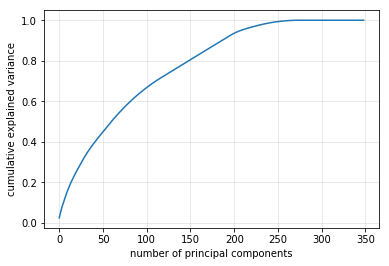

In [955]:
plot_explained_variance(349, X_training)

## Read first 100 test dataset

In [604]:
base_url = 'https://ivc.ischool.utexas.edu/VizWiz/data'
split2 = 'test'
annFile2 = '%s/Annotations/%s.json'%(base_url, split2)
imgDir2 = '%s/Images'%base_url
print(annFile2)
print(imgDir2)

# Retrieve file from URL and store it locally
annotations2 = requests.get(annFile2, allow_redirects=True)
print(annotations2.status_code)

test_data = pd.DataFrame(columns=['image','question'])
test_labels = annotations2.json()

https://ivc.ischool.utexas.edu/VizWiz/data/Annotations/test.json
https://ivc.ischool.utexas.edu/VizWiz/data/Images
200


In [606]:
test_labels = annotations2.json()

for vq in test_labels[0:100]:
    
    image_name = vq['image']
    question = vq['question']
    
    test_sample = pd.DataFrame({'image':[image_name], 'question':[question]})
    test_data = pd.concat([test_data,test_sample], ignore_index=True)

print(test_data.isnull().any())
print(test_data.shape)
test_data.head(5)

image       False
question    False
dtype: bool
(100, 2)


,image,question
0,VizWiz_test_000000020000.jpg,What is this? And what color is it?
1,VizWiz_test_000000020001.jpg,What is this?
2,VizWiz_test_000000020002.jpg,Has this oven gotten up to four hundred fifty ...
3,VizWiz_test_000000020003.jpg,What is this?
4,VizWiz_test_000000020004.jpg,What is this?


In [607]:
%store test_data

Stored 'test_data' (DataFrame)


In [622]:
test_image_features = process_images(df)

In [623]:
test_image_features.shape

(600, 5)

In [637]:
def text_features(input_df, to_csv=False, csv_name=None):
    keywords_dict = process_questions(df)
    text_features = pd.DataFrame(keywords_dict['documents'])
    cleaned = clean_text_features(text_features)
    cleaned.rename(index=str, columns={"id":"index", "keyPhrases":"keywords"}, inplace=True)
    if to_csv:
        cleaned.to_csv(csv_name, sep=',')
    return cleaned

In [631]:
test_image_features.to_csv('test_image_features.csv', sep=',')

In [638]:
test_text_features = text_features(test_data, to_csv=True, csv_name='test_text_features.csv')

In [934]:
cleaned_text_features_test = clean_text_features(test_text_features)

cleaned_text_features.rename(index=str, columns={"id":"index", "keyPhrases":"keywords"}, inplace=True)

cleaned_text_features.to_csv('text_features_test.csv', sep=',')

image = image_features.copy()
text = cleaned_text_features.copy()
orig = df.copy()[['index','answerable']]

text['index'] = text['index'].astype('int64')

test_features = text.merge(image, on='index', left_index=True, validate='one_to_one').merge(orig, on='index', left_index=True, validate='one_to_one').set_index('index')

test_features.reset_index(inplace=True)

In [935]:
test_features.reset_index(inplace=True)
test_features['keywords'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
test_features['keywords'] = features['keywords'].str.lower()
test_features.isnull().any()

level_0            False
index              False
keywords           False
img_name           False
color_histogram    False
orb                 True
sift                True
answerable         False
dtype: bool

In [953]:
test_features = count_keypoints(test_features)
test_features['keywords'].fillna(value='0', inplace=True)

In [960]:
X_testing = features[['keywords', 'num_of_keypoints']].values
Y_testing = features['answerable'].values.astype(float)

# convert keywords to vectors
testing_corpus = X_testing[:,0]
testing_corpus_vec = vec2.transform(testing_corpus)
testing_text = testing_corpus_vec.toarray()
testing_text.shape

# join with visual feature (num of keypoints)
X_testing = np.c_[testing_text, X_testing[:,1]]
print(X_testing.shape)

# standardize and PCA dim reduction
X_testing_scaled = sc2.transform(X_testing)
preprocess_pca(X_training, X_testing, dim=250)

# predict
Y_pred = majority_vote_predictor(X_training, X_testing, Y_training)

(600, 379)


In [961]:
Y_pred.shape

(600,)

### (d) You must submit the test prediction results from your classiffication system for the first 100 examples in the test split: i.e., VizWiz test 000000020000.jpg { VizWiz test 000000020099.jpg. This must be submitted in a csv or excel file with the prediction listed in the first 100 rows in column A, where 1 indicates answerable and 0 indicates unanswerable. (Code)

In [964]:
np.savetxt('y_pred.csv', Y_pred, delimiter=',')
# csv emailed

###  (e) Write 2-3 paragraphs describing your proposed prediction method. Describe the implementation of your proposed approach in such a way that a 1) reader could reproduce your set-up and 2) understand why you made your design decisions.

### (f) Write 2-3 paragraphs describing the analysis you conducted with the training and/or validation datasets that guided your choice for your prediction system design (e.g., hyperparameters, classiffication models, etc).

Due to some problem with Azure text analytics and OpenCV's extra modules, I did not have sufficient time to improve the models. The current setup provides an ensemble classifier that barely outperform the trivial solution.

- Import training and testing data 
- Check for class distribution
- Extract image-based features: SIFT key points. Other potentially helpful features: color histogram (RGB), ORB and KAZE. 
- Extract text-based features: extract keywords from Azure text analytics, get bag of word across all training examples. 
- Fill in missing values
- Combine text and image features as X
- Standardize X and perform PCA for dimensionality reduction
- Test performances of ifferent probabilistic classifiers with training data to find optimal tuning parameters (logistic regression, linear discriminant analysis, K nearest neighbors and random forest classifier)
- Set up optimal tuning parameters and combine into majority vote classifier
- Fit majority vote classifier with entire training data
- Preprocess test data with the same process and predict using fit classifier

Potential improvements:
- Adjust threshold function for logistic regression to account for prior. 
- Under/oversample to address imbalance between two classes.
- Instead of using the number of keypoints as feature, perform K-means clustering on SIFT keypoints.
- Improve keyword extraction for text-based questions. Azure text analytics mistakenly recognized some words as stopping words (eg. "Is this a can?" or "What is this?") and results empty fields. Manually defining stop words specific to this dataset may also help (eg. removing "thank you" or salutations).
- Explore another way to represent keywords (bag-of-word resulted large sparse matrices).
- Determine metrics to evaluate image quality and use this as a feature to predict answerability.
- Use saliency map or object recognition with higher level semantic understanding to extract visual features.

The models above did not explore any high level visual feature, and the result is very similar to the trivial classifier. Parameter tuning was cross-validated on a subset of the training data (500 samples) and tested on the remainder (100 samples). Most classifiers did not outperform the naive baseline. Further data cleansing and representations are very likely to help improve accuracy.

Since the overall goal is multimodal, an improved setup is to use high-level features for both image and text tasks. Examples with matching keywords from both the image and the text are more likely to have a label of 1 (answerable). The task can be decomposed into multiple levels, in the order from low-level features to high-level semantics:

- low-level
 - easy (likely to be 1 or answerable): keywords that matches low level visual features. eg: "what color is this shirt?"
 - difficult (likely to be 0 or unanswerable): no keywords successfully extracted (eg. "What does this can say?"); image is blank/black/blurry or otherwise illegible
 
- mid-level
 - easy: transcription-related task ("What's the brand of this" or "How much is this bill worth")
 - difficult: photo or question lacking relevant information (eg. "What's in this box?" when the box is closed)
 
- high-level
 - easy: object recognition when key items in the image matching keywords extracted from the questions, scene understanding when photo and question are well-articulated, etc.
 - difficult: semantically correct visual and textual information, but the question involves information that goes beyond what's provided (eg. "what's the expiration date" when the photo of a can doesn't include such information, or the photo doesn't include a can) or, in the case of automated VQA, goes beyond the capacity of the algorithm to answer the question.
 
The answerability depends on the information in both image and text, as well as the agent's capacity (human vs machine). In the ideal situation, information in the image should complement/match the question so that a human or an automated system can easily find answer to the question in the image. It seems that many questions are about identifying objects, so another way to predict answerability is to perform automatic object detection on the image and incorporate performance as a feature. 

## 2. Classification Using neural networks
### (a) Load MNIST and create a 70/30 train/test split.

In [11]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import keras
from sklearn.metrics import accuracy_score
import pandas
# from tensorflow.contrib.learn import DNNClassifier, SKCompat
# from tensorflow.contrib.learn import infer_real_valued_columns_from_input
# from tensorflow.estimator import RunConfig
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
from ipykernel import kernelapp as app
import matplotlib.pyplot as plt
from keras import layers

/Users/edithzeng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

mnist = fetch_mldata('MNIST original')

print(mnist['data'].shape, mnist['target'].shape)

X_train, X_test, Y_train, Y_test = train_test_split(mnist['data'], mnist['target'], test_size=.3, random_state=1)

(70000, 784) (70000,)


### (b) Optimize hyperparameters: find the optimal number of hidden layers (at least 10 different values) and number of neurons per layer (at least 10 different values) when training a multilayer perception (MLP). Set all other parameters constant when training; e.g., activation function, number of iterations for training, batch size, and gradient descent approach. (Code)

In [13]:
batch_size = 50
epochs = 20
num_classes = 10

In [14]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print(X_train.shape, 'train samples')
print(X_test.shape, 'test samples')

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

(49000, 784) train samples
(21000, 784) test samples


In [41]:
# https://keras.io/getting-started/sequential-model-guide/
# https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py

def test_MLP_param(nodes_per_layer, num_of_layers, get_weights=False):
    
    model = Sequential()
    
    # first hidden layer
    model.add(Dense(nodes_per_layer, activation='relu', input_shape=(784,)))
    

    # subsequent hidden layers
    for layer in range(1, num_of_layers-1):
        model.add(Dense(nodes_per_layer, activation='relu'))
    
    # output layer with 10 nodes for 10 classes
    model.add(Dense(10, activation='softmax'))

    # compile and fit model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_test, Y_test))
    
    if get_weights:
        num_of_params = 0
        for layer in model.layers:
            w = layer.get_weights()
            print("Layer {}: bias = {}, weights = {}\n".format(layer, w[0], w[1]))
            num_of_params += (len(w[0]) + len(w[1])) 
        print("Total number of weights and biases:", num_of_params)
            
    # return accuracy for current num of layer
    score = model.evaluate(X_test, Y_test, verbose=1)
    accuracy = score[1]
    
    return accuracy

In [ ]:
# testing different number of layers (each with 10 neurons)
layers = [i for i in range(1,11)]
layers_accuracy_score = []

for option in layers:
    layers_accuracy_score.append(test_MLP_param(nodes_per_layer=50, num_of_layers=option))

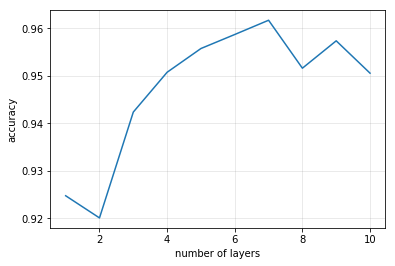

In [10]:
plt.xlabel("number of layers")
plt.ylabel("accuracy")
plt.grid(color='grey',linestyle='-',alpha=0.2)
plt.plot(layers, layers_accuracy_score)

In [ ]:
nodes = [20, 30, 50, 70, 100, 120, 150, 200, 250, 300]
nodes_accuracy_score = []

# test for optimal num of nodes (same # of nodes in each layer)
for option in nodes:
    nodes_accuracy_score.append(test_MLP_param(nodes_per_layer=option, num_of_layers=7))

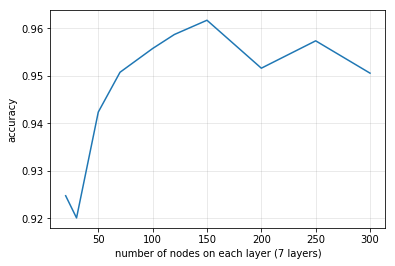

In [12]:
plt.xlabel("number of nodes on each layer (7 layers)")
plt.ylabel("accuracy")
plt.grid(color='grey',linestyle='-',alpha=0.2)
plt.plot(nodes, layers_accuracy_score)

### (c) Report the optimal hyperparameters you found and the number of weights that are in this optimal model. (Write-up)
### (d) Write a discussion about the performance of the neural network when using different hyperparameters. For example, what number of hidden layers and neurons per layer did better/worse and why do you think so? Your discussion should consist of 2-4 paragraphs. (Write-up)

In [42]:
accuracy = test_MLP_param(150, 7, get_weights=True)

Layer <keras.layers.core.Dense object at 0x1c320bda20>: bias = [[-0.050719   -0.06124026 -0.06141499 ... -0.01306954  0.04096607
  -0.04892495]
 [-0.02555107  0.03284898  0.05143164 ...  0.01631623 -0.07018594
  -0.06427863]
 [ 0.02303829 -0.03414132 -0.05403645 ...  0.04053457  0.04888926
   0.03526638]
 ...
 [ 0.02383086 -0.02620479  0.07356766 ... -0.02539464 -0.06050574
   0.07246447]
 [ 0.06164294  0.056353    0.03035923 ...  0.00989669  0.0163374
   0.05951668]
 [-0.00484464  0.01778103 -0.03074675 ... -0.00338892  0.00380412
   0.05833474]], weights = [-0.08296271  0.08073547  0.01081799 -0.02497147  0.13046764  0.08143789
 -0.09916192 -0.03514722 -0.05904397 -0.10226648 -0.0514484  -0.03997611
  0.02830913 -0.01251563  0.08941393  0.06353028 -0.06410564 -0.0270458
  0.02358783 -0.06402537 -0.08527648 -0.02862679  0.01904109  0.07588769
 -0.05642206  0.09437016  0.15128666  0.03050689  0.03109527 -0.1582271
  0.03514146 -0.05009764 -0.07516615 -0.15263942  0.03383524 -0.02563958

Layer <keras.layers.core.Dense object at 0x1c32545d68>: bias = [[ 0.04172406 -0.10078906 -0.491488   ...  0.01958196 -0.16575585
   0.08645366]
 [-0.55278635 -0.40820527 -0.05706439 ... -0.10045129 -0.0264737
   0.05908872]
 [ 0.11393718  0.0911247   0.10272958 ... -0.33233657  0.11393523
   0.09127951]
 ...
 [ 0.00640169 -0.1893836  -0.26626158 ...  0.08385722  0.13328674
   0.09454715]
 [-0.2139064   0.06891532  0.06353159 ... -0.13116114 -0.18272813
  -0.36755666]
 [-0.3136107   0.06397653 -0.12631705 ... -0.29465476 -0.02937835
   0.12253556]], weights = [-0.03812976 -0.15220971  0.06029774 -0.10208245 -0.01077733  0.11289982
 -0.19938987 -0.08685791  0.1788317   0.08341153]

Total number of weights and biases: 2594
21000/21000 [==============================] - 1s 64us/step


In [20]:
accuracy

0.977

Since I tested with the same number of neurons (150) for each layer, the resulted NN is a rather complex model with 2,594 weights and biases. It can be further fine-tuned by varying the number of neurons on each layer to achieve better accuracy.

The fully-connected NN has three hyperparameters:
- number of layers $(7)$
- number of neurons per layer $(150)$
- weights and biases $(2594)$

The plots above suggest that the NN's performance significantly improved when the number of layer inreased from 1 to 7. With 7 layers, adding more neurons to each layer also helped to improve accuracy. Since the model is fairly complex with over 2000 weights and biases, adding more layers or more neurons per layer after the optimal point affected the overall performance. This is likely due to overfitting.